In [1]:
import os
import numpy as np
import glob
import argparse
import random

In [2]:
class_ids = {'spoof':0, 'bonafide': 1}

In [3]:
def create_meta(files_list,store_loc,mode='train'):
    if not os.path.exists(store_loc):
        os.makedirs(store_loc)
    
    if mode=='train':
        meta_store = store_loc+'/lj_training.txt'
        fid = open(meta_store,'w')
        for filepath in files_list:
            fid.write(filepath+'\n')
        fid.close()
    elif mode=='test':
        meta_store = store_loc+'/lj_testing.txt'
        fid = open(meta_store,'w')
        for filepath in files_list:
            fid.write(filepath+'\n')
        fid.close()
    elif mode=='validation':
        meta_store = store_loc+'/lj_validation.txt'
        fid = open(meta_store,'w')
        for filepath in files_list:
            fid.write(filepath+'\n')
        fid.close()
    else:
        print('Error in creating meta files')

In [4]:
data_rootdir = '/nas/rishith/datasets/smaller_dbs/DataSets/Combined_LJ/'

bonaTrainFolder = data_rootdir + "Train/orig_com"
fakeTrainFolder = data_rootdir + "Train/fake_com"

bonaTrainFiles = sorted(glob.glob(bonaTrainFolder+'/*.wav'))
fakeTrainFiles = sorted(glob.glob(fakeTrainFolder+'/*.wav'))

In [5]:
print(len(bonaTrainFiles))
print(len(fakeTrainFiles))

451
451


In [6]:
bonaValidationFilesAfterSplit = random.sample(bonaTrainFiles, int(len(bonaTrainFiles)*0.1))
bonaTrainFilesAfterSplit = set(bonaTrainFiles) - set(bonaValidationFilesAfterSplit)

fakeValidationFilesAfterSplit = random.sample(fakeTrainFiles, int(len(fakeTrainFiles)*0.1))
fakeTrainFilesAfterSplit = set(fakeTrainFiles) - set(fakeValidationFilesAfterSplit)

In [7]:
train_lists=[]
val_lists=[]

In [8]:
for audioPath in list(bonaTrainFilesAfterSplit):
    to_write = audioPath+' '+str(class_ids['bonafide'])
    train_lists.append(to_write)
    
for audioPath in list(fakeTrainFilesAfterSplit):
    to_write = audioPath+' '+str(class_ids['spoof'])
    train_lists.append(to_write)

In [9]:
for audioPath in bonaValidationFilesAfterSplit:
    to_write = audioPath+' '+str(class_ids['bonafide'])
    val_lists.append(to_write)

for audioPath in fakeValidationFilesAfterSplit:
    to_write = audioPath+' '+str(class_ids['spoof'])
    val_lists.append(to_write)

In [10]:
bonaTestFolder = data_rootdir + "Test/orig_com"
fakeTestFolder = data_rootdir + "Test/fake_com"

bonaTestFiles = sorted(glob.glob(bonaTestFolder+'/*.wav'))
fakeTestFiles = sorted(glob.glob(fakeTestFolder+'/*.wav'))

In [12]:
test_lists = []
for audioPath in bonaTestFiles:
    to_write = audioPath+' '+str(class_ids['bonafide'])
    test_lists.append(to_write)

for audioPath in fakeTestFiles:
    to_write = audioPath+' '+str(class_ids['spoof'])
    test_lists.append(to_write)

In [13]:
len(test_lists)

98

In [14]:
meta_store_path = 'meta/'
# create_meta(train_lists,meta_store_path,mode='train')
create_meta(test_lists,meta_store_path,mode='test')
# create_meta(val_lists,meta_store_path,mode='validation')

# Train

In [ ]:
# Run in terminal to train
# python 1.training_xvector_lj.py

# Test

In [20]:
# infer.py

import os
import sys
import numpy as np
import torch
import yaml
from models.x_vector_Indian_LID import X_vector

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device ="cpu"

num_classes = 2
# model = get_model(device, num_classes, pretrained=False)
input_dim = 257

model = X_vector(input_dim, num_classes).to(device)

#checkpoints = torch.load(sys.argv[1])

checkpoints = torch.load("./save_model/best_check_point_14_0.033093832132484145",map_location=torch.device('cpu'))

model.load_state_dict(checkpoints['model'])

model.eval()

X_vector(
  (tdnn1): TDNN(
    (kernel): Linear(in_features=1285, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.5, inplace=False)
  )
  (tdnn2): TDNN(
    (kernel): Linear(in_features=1536, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.5, inplace=False)
  )
  (tdnn3): TDNN(
    (kernel): Linear(in_features=1024, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.5, inplace=False)
  )
  (tdnn4): TDNN(
    (kernel): Linear(in_features=512, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.5, inplace=False)
  )
  (tdnn5): TDNN(
    (kernel): Linear(in_features=512, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.5, inplace=False)
  )
  (segment6): Linear(in_features=1024, out_features=512, bias=True)
  (segment7): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
  (s

In [24]:
def validation(dataloader, epoch):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, sample_batched in enumerate(dataloader):
#             print(sample_batched[0][0].shape)
            features = torch.from_numpy(np.array([torch_tensor.numpy().T for torch_tensor in sample_batched[0]])).float()
            labels = torch.from_numpy(np.asarray([torch_tensor[0].numpy() for torch_tensor in sample_batched[1]]))
            features, labels = features.to(device),labels.to(device)
            pred_logits,x_vec = model(features)
            #### CE loss
#             loss = loss_fun(pred_logits,labels)
#             val_loss_list.append(loss.item())
            #train_acc_list.append(accuracy)
            predictions = np.argmax(pred_logits.detach().cpu().numpy(),axis=1)
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)
                
        mean_acc = accuracy_score(full_gts,full_preds)
#         mean_loss = np.mean(np.asarray(val_loss_list))
        print('Total Validation accuracy {} after {} epochs'.format(mean_acc,epoch))

In [25]:
from utils.utils import speech_collate
from SpeechDataGenerator import SpeechDataGenerator
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

dataset_val = SpeechDataGenerator(manifest='meta/lj_validation.txt',mode='train')
dataloader_val = DataLoader(dataset_val, batch_size=1,shuffle=True,collate_fn=speech_collate) 

dataset_test = SpeechDataGenerator(manifest='meta/lj_testing.txt',mode='test')
dataloader_test = DataLoader(dataset_test, batch_size=1,shuffle=True,collate_fn=speech_collate) 

In [28]:
validation(dataloader_val, 15)

Total Validation accuracy 0.9888888888888889 after 15 epochs


In [29]:
validation(dataloader_test, 15)

Total Validation accuracy 1.0 after 15 epochs


In [30]:
dataset_val = SpeechDataGenerator(manifest='meta/cmu_validation.txt',mode='train')
dataloader_val = DataLoader(dataset_val, batch_size=1,shuffle=True,collate_fn=speech_collate) 

dataset_test = SpeechDataGenerator(manifest='meta/cmu_testing.txt',mode='test')
dataloader_test = DataLoader(dataset_test, batch_size=1,shuffle=True,collate_fn=speech_collate) 

In [31]:
validation(dataloader_val, 15)

Total Validation accuracy 0.5 after 15 epochs


In [32]:
validation(dataloader_test, 15)

Total Validation accuracy 0.5 after 15 epochs


In [33]:
dataset_val = SpeechDataGenerator(manifest='meta/libri_validation.txt',mode='train')
dataloader_val = DataLoader(dataset_val, batch_size=1,shuffle=True,collate_fn=speech_collate) 

dataset_test = SpeechDataGenerator(manifest='meta/libri_testing.txt',mode='test')
dataloader_test = DataLoader(dataset_test, batch_size=1,shuffle=True,collate_fn=speech_collate) 

In [34]:
validation(dataloader_val, 15)

Total Validation accuracy 0.5135135135135135 after 15 epochs


In [35]:
validation(dataloader_test, 15)

Total Validation accuracy 0.5 after 15 epochs


In [82]:
a = next(iter(dataloader_test))

In [102]:
features = torch.from_numpy(np.asarray([torch_tensor.numpy().T for torch_tensor in a[0]]))

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [113]:
b = [torch_tensor.numpy().T for torch_tensor in a[0]]

In [114]:
type(b)

list

In [115]:
b

[array([[ 4.6749187 ,  3.8853543 ,  2.2085905 , ..., -0.31530532,
         -0.31531578, -0.31531802],
        [ 0.9983379 ,  0.49074042,  0.37574193, ..., -0.18206783,
         -0.18206747, -0.18206893],
        [ 0.20084183,  0.12161088,  0.01850133, ..., -0.15826242,
         -0.15826114, -0.15825993],
        ...,
        [ 0.80989695,  0.16179219,  0.1647071 , ..., -0.47767985,
         -0.4777358 , -0.477748  ],
        [-0.376021  ,  0.48656946,  1.1038606 , ..., -0.5463303 ,
         -0.54635173, -0.54637665],
        [ 0.4865891 ,  0.5026514 ,  0.64713675, ..., -0.55184567,
         -0.55180705, -0.55181056]], dtype=float32),
 array([[-0.1790482 ,  0.36278582,  0.9705806 , ..., -0.422991  ,
         -0.42299685, -0.42300546],
        [ 0.96785605,  0.7562352 ,  0.29407862, ..., -0.35049757,
         -0.35049668, -0.35049823],
        [ 1.3569543 ,  1.0746098 ,  0.6611118 , ..., -0.3926355 ,
         -0.39263597, -0.39263654],
        ...,
        [ 0.4661072 ,  0.6404588 ,  1.1

In [116]:
torch.from_numpy(b)

TypeError: expected np.ndarray (got list)

# AASIST Filters

In [125]:
out_channels = 70
kernel_size = 129
sample_rate = 16000

In [127]:
def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)


def to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

In [128]:
NFFT = 512
f = int(sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
fmel = to_mel(f)
fmelmax = np.max(fmel)
fmelmin = np.min(fmel)
filbandwidthsmel = np.linspace(fmelmin, fmelmax, out_channels + 1)
filbandwidthsf = to_hz(filbandwidthsmel)

In [130]:
from torch import Tensor

In [131]:
mel = filbandwidthsf
hsupp = torch.arange(-(kernel_size - 1) / 2,
                          (kernel_size - 1) / 2 + 1)
band_pass = torch.zeros(out_channels, kernel_size)
for i in range(len(mel) - 1):
    fmin = mel[i]
    fmax = mel[i + 1]
    hHigh = (2*fmax/sample_rate) * \
        np.sinc(2*fmax*hsupp/sample_rate)
    hLow = (2*fmin/sample_rate) * \
        np.sinc(2*fmin*hsupp/sample_rate)
    hideal = hHigh - hLow

    band_pass[i, :] = Tensor(np.hamming(
        kernel_size)) * Tensor(hideal)

In [133]:
band_pass.shape

torch.Size([70, 129])

In [134]:
import matplotlib.pyplot as plt

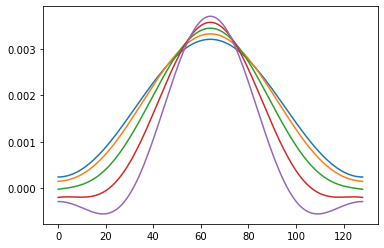

In [144]:
plt.figure()
for i in range(5):
    plt.plot(band_pass[i])
plt.show()

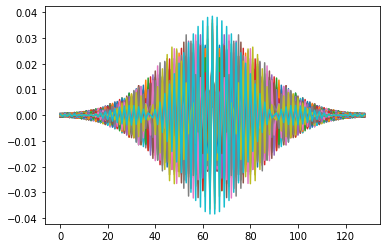

In [140]:
plt.figure()
for i in range(70):
    plt.plot(band_pass[i])
plt.show()

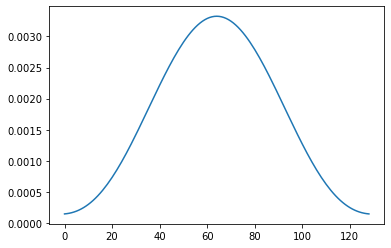

In [136]:
plt.figure()
plt.plot(band_pass[1])
plt.show()

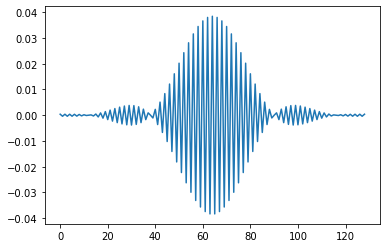

In [141]:
plt.figure()
plt.plot(band_pass[-1])
plt.show()